In [22]:
# imports 
import pandas as pd
import joblib
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


In [4]:
# Load data

data_balanced = pd.read_csv('../Helper_csv-s/data_balanced.csv')
data_balanced = data_balanced.drop(columns=["Unnamed: 0", "ID"])

In [5]:
# Copy nessasary code from 01_notebook


# 1. Split dataset

X = data_balanced.drop("default", axis=1)
y = data_balanced["default"]

# Split original X
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Standardize using all rows of X, then match indices
stdX = (X - X.mean()) / X.std()

# Align standardized train/test with the split
stdX_train = stdX.loc[X_train.index]
stdX_test = stdX.loc[X_test.index]


# 2. Models 

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)


rf = RandomForestClassifier(
    n_estimators=300,     
    max_depth=None,        
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=1              
)


### RandomForest

#### Feature selection

In [6]:
# RFECV for automatic feature selection
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=5,
    scoring='roc_auc',
    n_jobs=1
)

rfecv.fit(stdX_train, y_train)

# Selected features
selected_features = stdX_train.columns[rfecv.support_]

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:")
print(list(selected_features))


Optimal number of features: 23
Selected features:
['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [7]:
# RFE

rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(stdX_train, y_train)

selected = stdX_train.columns[rfe.support_]
print("Selected features:", list(selected))

Selected features: ['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2']


#### Hyperparameters

In [16]:
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,  # number of random combinations to try
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(stdX_train, y_train)
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 18, 'n_estimators': 279}
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   3.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   7.4s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   7.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=6, min_samples_split=3, n_estimators=291; total time=   4.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=13, n_estimators=413; total time=   7.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=13, n_estimators=413; total time=   7.5s
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=4, n_es

Exception ignored in: <function ResourceTracker.__del__ at 0x107bb9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   3.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   7.5s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, min_samples_split=3, n_estimators=443; total time=   7.1s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=6, min_samples_split=3, n_estimators=291; total time=   4.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=13, n_estimators=413; total time=   7.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=13, n_estimators=413; total time=   8.0s
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=406; total time=  32.4s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=149; total time=   2.8s
[CV] END max_depth=30, max_features=lo

Exception ignored in: <function ResourceTracker.__del__ at 0x1033a1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   3.1s
[CV] END max_depth=20, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=  33.0s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=11, n_estimators=287; total time=   5.4s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=7, min_samples_split=19, n_estimators=487; total time=   7.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=445; total time=   7.4s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=445; total time=   7.6s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=16, n_estimators=363; total time=   6.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=149; total time=   2.9s
[CV] END max_depth=30, max_feat

Exception ignored in: <function ResourceTracker.__del__ at 0x107b39bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=20, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=  32.2s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=11, n_estimators=287; total time=   5.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=406; total time=  31.3s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=149; total time=   2.8s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=6, min_samples_split=11, n_estimators=359; total time=   6.0s
[CV] END max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=13, n_estimators=261; total time=  23.1s
[CV] END max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=108; total time=  10.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=3, min_samples_split=18, n_estimators=491; total time=  42.9s
[CV] END max_depth=30, max_feature

Exception ignored in: <function ResourceTracker.__del__ at 0x104b4dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=221; total time=   3.0s
[CV] END max_depth=20, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=  35.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=7, min_samples_split=19, n_estimators=487; total time=   7.8s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=7, min_samples_split=19, n_estimators=487; total time=   7.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=445; total time=   7.6s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=16, n_estimators=363; total time=   6.0s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=16, n_estimators=363; total time=   6.1s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=6, min_samples_split=11, n_estimators=359; total time=   6.1s
[CV] END max_depth=10, max_featu

Exception ignored in: <function ResourceTracker.__del__ at 0x104ff9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107961bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=20, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=  32.1s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=11, n_estimators=287; total time=   5.8s
[CV] END max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=4, n_estimators=406; total time=  32.8s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=149; total time=   2.6s
[CV] END max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=13, n_estimators=261; total time=  22.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=17, n_estimators=336; total time=   5.1s
[CV] END max_depth=40, max_features=None, min_samples_leaf=1, min_samples_split=8, n_estimators=108; total time=  10.5s
[CV] END max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=330; total time=  29.6s
[CV] END max_depth=20, max_features=N

Exception ignored in: <function ResourceTracker.__del__ at 0x1023c9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106815bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


[CV] END max_depth=20, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=459; total time=  32.5s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=11, n_estimators=287; total time=   5.7s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=7, min_samples_split=19, n_estimators=487; total time=   7.7s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=7, min_samples_split=19, n_estimators=487; total time=   7.3s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=445; total time=   7.5s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=445; total time=   7.9s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=16, n_estimators=363; total time=   6.0s
[CV] END max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=13, n_estimators=261; total time=  23.2s
[CV] END max_depth=10, max_fe

In [9]:
# the best parameters 

optimized_rf = RandomForestClassifier(
    n_estimators=279,
    max_depth=10,
    max_features='log2',
    min_samples_leaf=7,
    min_samples_split=18,
    random_state=42,
    n_jobs=-1
)



In [11]:
# Update train dataset

stdX_train_selected = stdX_train[selected]
stdX_test_selected = stdX_test[selected]

# Fit the optimized RF model
optimized_rf.fit(stdX_train_selected, y_train)

# Predict 
y_pred = optimized_rf.predict(stdX_test_selected)

# Performance evaluation 
print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n", 
      classification_report(y_test, y_pred))


Accuracy: 0.7004018081366148

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73      1991
           1       0.75      0.60      0.67      1991

    accuracy                           0.70      3982
   macro avg       0.71      0.70      0.70      3982
weighted avg       0.71      0.70      0.70      3982



In [12]:
# Update dataset

stdX_train_sel = stdX_train[selected_features]
stdX_test_sel = stdX_test[selected_features]

# Fit
optimized_rf.fit(stdX_train_sel, y_train)

# Predict
y_pred = optimized_rf.predict(stdX_test_sel)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.7074334505273732

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.78      0.73      1991
           1       0.74      0.63      0.68      1991

    accuracy                           0.71      3982
   macro avg       0.71      0.71      0.71      3982
weighted avg       0.71      0.71      0.71      3982



### XGBoost

#### Feature selection

In [14]:
# RFECV
rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

rfecv.fit(stdX_train, y_train)

selected_features = stdX_train.columns[rfecv.support_]

print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", list(selected_features))


Optimal number of features: 21
Selected features: ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [15]:
# Update dataset

X_train_sel = stdX_train[selected_features]
X_test_sel = stdX_test[selected_features]

# Hyperparameter optimization 

param_dist = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}


search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring='roc_auc',
    cv=5,
    n_iter=25,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_sel, y_train)

print("Best parameters:", search.best_params_)
print("Best AUC:", search.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best AUC: 0.7828682530725655


In [18]:
# Final model

X_train_sel = stdX_train[selected_features]
X_test_sel = stdX_test[selected_features]


final_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.6,
    colsample_bytree=0.8,
    min_child_weight=5,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=1    
)


# Fit
final_xgb.fit(X_train_sel, y_train)

# Predict 
y_pred = final_xgb.predict(X_test_sel)
y_proba = final_xgb.predict_proba(X_test_sel)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 0.7099447513812155

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.78      0.73      1991
           1       0.75      0.64      0.69      1991

    accuracy                           0.71      3982
   macro avg       0.71      0.71      0.71      3982
weighted avg       0.71      0.71      0.71      3982



###  Models Comparison

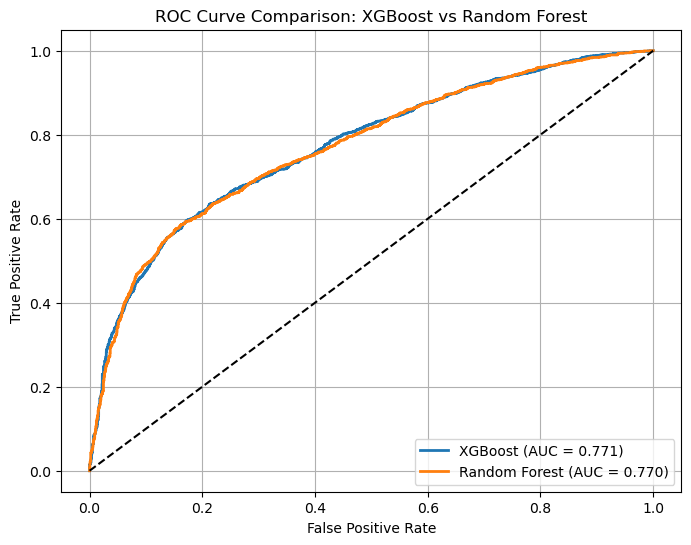

AUC Comparison:
XGBoost AUC:        0.7715
Random Forest AUC:  0.7700


In [21]:
# XGBoost Scores
y_proba_xgb = final_xgb.predict_proba(X_test_sel)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Random forest scores
y_proba_rf = optimized_rf.predict_proba(stdX_test_sel)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# Plot comparison
plt.figure(figsize=(8, 6))

plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})", linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)


plt.plot([0, 1], [0, 1], 'k--') # Diagonal line for random guessing

plt.title("ROC Curve Comparison: XGBoost vs Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("AUC Comparison:")
print(f"XGBoost AUC:        {auc_xgb:.4f}")
print(f"Random Forest AUC:  {auc_rf:.4f}")


In [23]:
joblib.dump(optimized_rf, "../Model/optimized_random_forest_model.pkl")


['../Model/optimized_random_forest_model.pkl']